In [12]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns
import pickle
import copy
import jaxopt

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot
import src.exp_utils as exp_utils
import experiments.tail as exp_tail

plt.rcParams["mathtext.fontset"] = "cm"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load

In [73]:
n = 500
d = 1
res_stats = pickle.load(open(f"../data/tail_mm/stats_n{n}_d{d}.pkl", "rb"))

dof_ls = list(res_stats.keys())
dof_ls

[3, 5, 10, 20, 50, 100, 200]

In [85]:
# change theta
dof_threshold_ls = [5, 10, 20]
plot_df_ls = {}
nu_lb = {}

for i, dof_thresh in enumerate(dof_threshold_ls):
    # change theta
    res_stats_new = copy.deepcopy(res_stats)
    for dof in dof_ls:
        tau = np.array(res_stats[dof]["tilted_r_boot"]["tau"])
        theta_new = exp_tail.compute_theta_fat_tail(dof_thresh, tau)
        
        res_stats_new[dof] = exp_utils.change_theta(res_stats_new[dof], ["tilted_r_boot"], theta_new)

        nu_lb[dof] = dof_thresh
    
    methods = {"standard": "IMQ", "tilted": "Tilted", "tilted_r_boot": "R-KSD"}
    
    plot_df = {"dof": [], "nonsq_stat": [], "method": [], "rej": [], "dof_lb": []}
    for dof in dof_ls:
        for m, m_label in methods.items():
            rr = res_stats_new[dof][m]
            plot_df["nonsq_stat"].extend(np.array(rr["nonsq_stat"]).tolist())
            plot_df["dof"].extend([dof] * len(rr["nonsq_stat"]))
            
            plot_df["rej"].extend(rr["rej"])
            plot_df["method"].extend([m_label] * len(rr["nonsq_stat"]))

            plot_df["dof_lb"].extend([nu_lb[dof]] * len(rr["nonsq_stat"]))
    
    plot_df = pd.DataFrame(plot_df)
    plot_df_ls[dof_thresh] = plot_df

/tmp/ipykernel_822503/2268952931.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_plot_df.replace({"method": {"R-KSD": rf"R-KSD ($\nu_0$={dof_threshold_ls[i]})"}}, inplace=True)


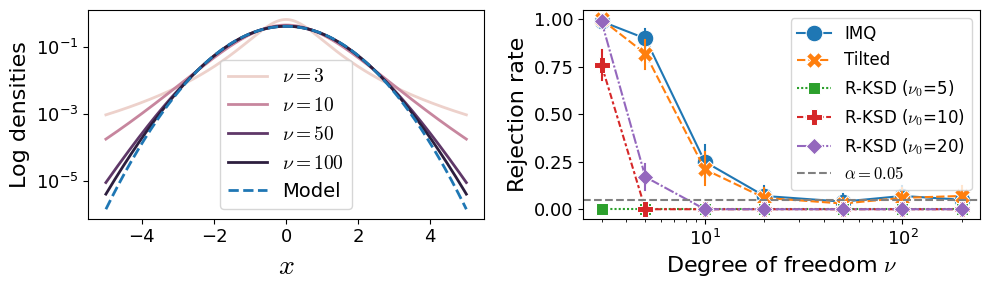

In [86]:
_, axes = plt.subplots(ncols=2, figsize=(10, 3))

# 1. show model and data densities
x_plot = jnp.linspace(-5., 5., 1001)
model_pdf = jax.scipy.stats.norm.pdf(x_plot)

den_df = {"x": [], "den": [], "dof": []}
for dof in [3, 10, 50, 100]:
    data_pdf = exp_tail.t_pdf_multivariate(x_plot.reshape((-1, 1)), df=dof).tolist()
    den_df["x"].extend(x_plot.tolist())
    den_df["den"].extend(data_pdf)
    den_df["dof"].extend([dof] * len(x_plot))
den_df = pd.DataFrame(den_df)

ax = axes[0]
g1 = sns.lineplot(ax=ax, data=den_df, x="x", y="den", hue=np.log(den_df.dof), legend="full", linewidth=2)
g2 = ax.plot(x_plot, model_pdf, color="C0", linestyle="--", label="Model", linewidth=2)
ax.set_xlabel(r"$x$", fontsize=20)
ax.set_ylabel("Log densities", fontsize=16)
ax.set_yscale("log")
ax.tick_params(axis="both", labelsize=13)
ax.legend(handles=g1.get_legend().legend_handles + g2, labels=[rf"$\nu={r}$" for r in den_df.dof.unique().tolist()] + ["Model"], fontsize=14)

# 2. plot rej probs
# append results df and change method labels
plot_df = plot_df_ls[dof_threshold_ls[0]].copy()
plot_df = plot_df.loc[(plot_df.method == "IMQ") | (plot_df.method == "Tilted")]
for i, dof_thresh in enumerate(dof_threshold_ls):
    sub_plot_df = plot_df_ls[dof_thresh]
    sub_plot_df = sub_plot_df.loc[sub_plot_df.method == "R-KSD"]
    sub_plot_df.replace({"method": {"R-KSD": rf"R-KSD ($\nu_0$={dof_threshold_ls[i]})"}}, inplace=True)
    plot_df = pd.concat([plot_df, sub_plot_df], ignore_index=True)

ax = axes[1]
_ = sns.lineplot(ax=ax, data=plot_df, x="dof", y="rej", hue="method", style="method", markers=True, err_style="bars", markersize=12)
ax.axhline(0.05, color="grey", linestyle="--", label=r"$\alpha=0.05$")
ax.set_xlabel(r"Degree of freedom $\nu$", fontsize=16)
ax.set_ylabel("Rejection rate", fontsize=16)
ax.tick_params(axis="both", labelsize=13)
ax.set_ylim(-0.05, 1.05)
ax.set_xscale("log")

lgd = ax.legend(fontsize=12)
plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.savefig("../figs/robust/tail.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")

In [31]:
import scipy
from scipy.optimize import minimize as sci_minimize


0.3989422804014327

In [54]:
nu = 100
scale = jnp.sqrt((nu - 2) / nu)

normal_pdf = lambda x: scipy.stats.norm.pdf(x)
t_pdf = lambda x: scipy.stats.t.pdf(x, nu, scale=scale)

print("normal", normal_pdf(0.))
print(t_pdf(0.))
print(exp_tail.t_pdf_multivariate_single(x=jnp.array([0.]), df=nu, scale=scale))

normal 0.3989422804014327
0.40198634084504986
0.40198874


In [57]:
init_val = 1.
summary = sci_minimize(lambda x: (normal_pdf(x) - t_pdf(x))**2, init_val, method="BFGS")

In [58]:
print("expect identical", normal_pdf(summary.x), t_pdf(summary.x))

expect identical [0.24197072] [0.24074141]


Array(0.63661957, dtype=float32)